Do your work for this exercise in a jupyter notebook named feature_engineering within the regression-exercises repo. Add, commit, and push your work.










In [1]:
#import warnings
import warnings
warnings.filterwarnings("ignore")

#standard DS libraries
import pandas as pd
import numpy as np

import wrangle

#import visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

#import dataset
from pydataset import data

#sklearn imports
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

1. Load the tips dataset.


In [2]:
#load the data from pydataset 
tips= data('tips')

In [3]:
#take a look at the data
tips.head()

,total_bill,tip,sex,smoker,day,time,size
1,16.99,1.01,Female,No,Sun,Dinner,2
2,10.34,1.66,Male,No,Sun,Dinner,3
3,21.01,3.50,Male,No,Sun,Dinner,3
4,23.68,3.31,Male,No,Sun,Dinner,2
5,24.59,3.61,Female,No,Sun,Dinner,4


In [4]:
#check the datatypes and nulls
tips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 244 entries, 1 to 244
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 15.2+ KB


In [5]:
#verifying nulls
tips.isnull().sum()

total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64

In [6]:
def disc_cols(df):
    cat_cols= df.select_dtypes(include=['object']).columns.tolist()
    return cat_cols

def cont_cols(df):
    num_cols= df.select_dtypes(exclude=['object']).columns.tolist()
    return num_cols

a. Create a column named price_per_person. This should be the total bill divided by the party size.

In [7]:
#create another new column using the columns we already have
tips['price_per_person'] = tips['total_bill'] / tips['size'] 

In [8]:
cat_cols = disc_cols(tips)
cat_cols

['sex', 'smoker', 'day', 'time']

In [9]:
num_cols = cont_cols(tips)
num_cols

['total_bill', 'tip', 'size', 'price_per_person']

In [13]:
tips.head()

,total_bill,tip,sex,smoker,day,time,size,price_per_person
1,16.99,1.01,Female,No,Sun,Dinner,2,8.495000
2,10.34,1.66,Male,No,Sun,Dinner,3,3.446667
3,21.01,3.50,Male,No,Sun,Dinner,3,7.003333
4,23.68,3.31,Male,No,Sun,Dinner,2,11.840000
5,24.59,3.61,Female,No,Sun,Dinner,4,6.147500


b. Before using any of the methods discussed in the lesson, which features do you think would be most important for predicting the tip amount?


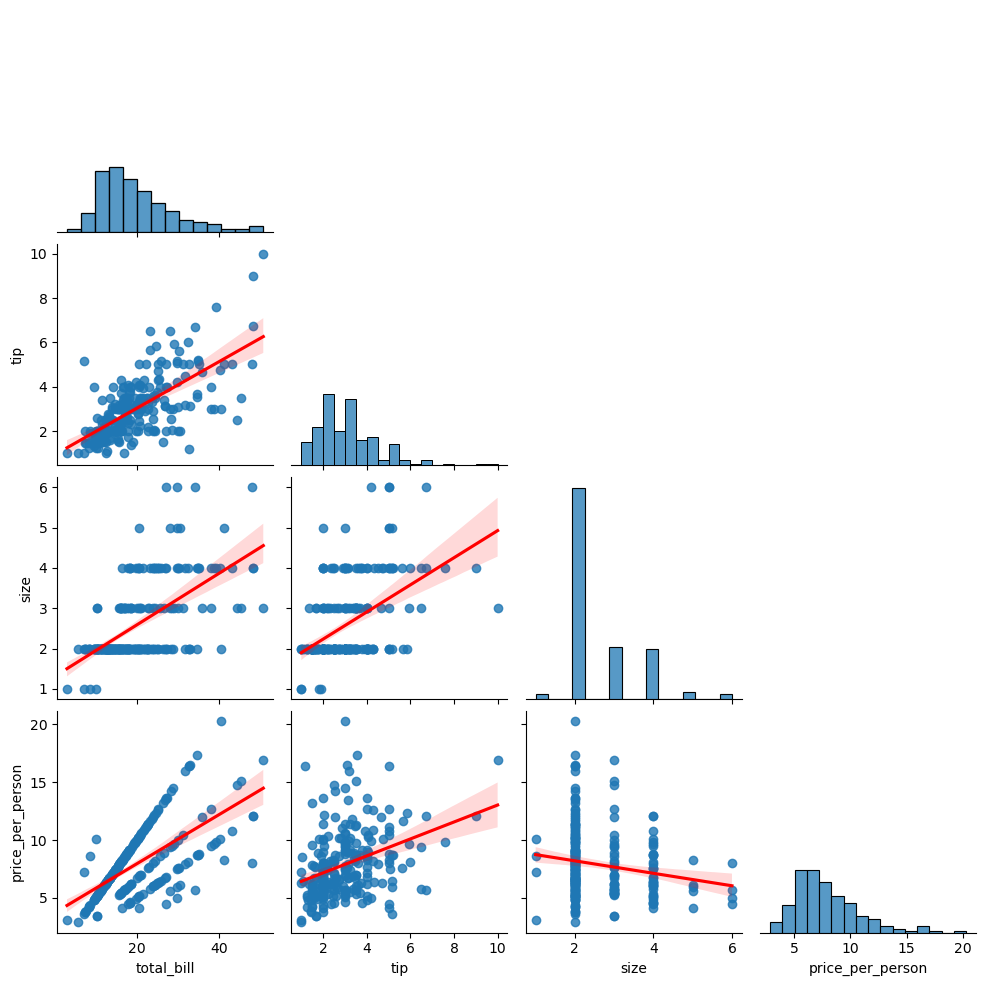

In [11]:
#pairplot to visualize correlation
sns.pairplot(data=tips, corner=True, kind="reg", plot_kws={'line_kws':{'color':'red'}})
plt.show()

In [17]:
tips_corr = tips[['total_bill', 'tip', 'size', 'price_per_person']]

In [18]:
tips_corr.corr()

,total_bill,tip,size,price_per_person
total_bill,1.000000,0.675734,0.598315,0.647497
tip,0.675734,1.000000,0.489299,0.347393
size,0.598315,0.489299,1.000000,-0.175412
price_per_person,0.647497,0.347393,-0.175412,1.000000


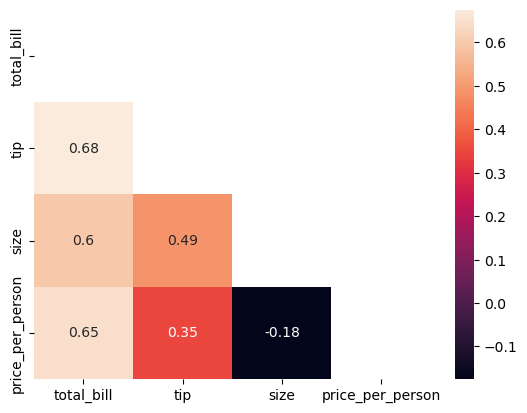

In [24]:
sns.heatmap(tips_corr.corr(), cmap='rocket', annot=True, mask= np.triu(tips_corr.corr()));
plt.show()

In [27]:
train, validate, test = wrangle.splitting_data(tips)

In [28]:
# X and y splits to scale
target = "tip"

X_train = train[['total_bill', 'size', 'price_per_person']]
y_train = train[target]

X_validate = validate[['total_bill', 'size', 'price_per_person']]
y_validate = validate[target]

X_test = test[['total_bill', 'size', 'price_per_person']]
y_test = test[target]

In [29]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, 37 to 110
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   total_bill        146 non-null    float64
 1   size              146 non-null    int64  
 2   price_per_person  146 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 4.6 KB


In [30]:
#assign to variable #need scaler for each independent variable
#create it
scaler = MinMaxScaler()

In [31]:
#fit it
scaler.fit(X_train)

MinMaxScaler()

In [32]:
#use it
#make a new column within train
#use 'transform' instead of 'predict'
X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

In [33]:
#Create dummy columns of my categorical features
train_dummy = pd.get_dummies(columns=['sex', 'smoker', 'day', 'time', 'size'], data=train)
train_dummy.head(3)

,total_bill,tip,price_per_person,sex_Female,sex_Male,smoker_No,smoker_Yes,day_Fri,day_Sat,day_Sun,day_Thur,time_Dinner,time_Lunch,size_1,size_2,size_3,size_4,size_5,size_6
37,16.31,2.00,5.436667,False,True,True,False,False,True,False,False,True,False,False,False,True,False,False,False
218,11.59,1.50,5.795000,False,True,False,True,False,True,False,False,True,False,False,True,False,False,False,False
64,18.29,3.76,4.572500,False,True,False,True,False,True,False,False,True,False,False,False,False,True,False,False


In [34]:
#Drop a couple columns that provide redundant information
train_dummy.drop(columns=['sex_Female', 'smoker_No'], inplace=True)
train_dummy.head(3)

,total_bill,tip,price_per_person,sex_Male,smoker_Yes,day_Fri,day_Sat,day_Sun,day_Thur,time_Dinner,time_Lunch,size_1,size_2,size_3,size_4,size_5,size_6
37,16.31,2.00,5.436667,True,False,False,True,False,False,True,False,False,False,True,False,False,False
218,11.59,1.50,5.795000,True,True,False,True,False,False,True,False,False,True,False,False,False,False
64,18.29,3.76,4.572500,True,True,False,True,False,False,True,False,False,False,False,True,False,False


In [35]:
#Instantiate the min-max scaler and fit/transform my continuous features
mms_dummy = MinMaxScaler()

#fit
mms_dummy.fit(train_dummy[['total_bill', 'price_per_person']])

#transform
train_dummy[['total_bill', 'price_per_person']] = mms_dummy.transform(train_dummy[['total_bill', 'price_per_person']])

In [36]:
train_dummy.head(3)

,total_bill,tip,price_per_person,sex_Male,smoker_Yes,day_Fri,day_Sat,day_Sun,day_Thur,time_Dinner,time_Lunch,size_1,size_2,size_3,size_4,size_5,size_6
37,0.292920,2.00,0.177401,True,False,False,True,False,False,True,False,False,False,True,False,False,False
218,0.188496,1.50,0.202216,True,True,False,True,False,False,True,False,False,True,False,False,False,False
64,0.336726,3.76,0.117555,True,True,False,True,False,False,True,False,False,False,False,True,False,False


In [37]:
#Create X and y dataframes
X_train_dummy = train_dummy.drop(columns=['tip'])
y_train_dummy = train_dummy['tip']

c. Use Select K Best to select the top 2 features for predicting tip amount. What are they?


In [38]:
#create
kbest = SelectKBest(score_func=f_regression, k=2)

In [39]:
#fit
kbest.fit(X_train_scaled, y_train)

SelectKBest(k=2, score_func=<function f_regression at 0x157b689a0>)

In [40]:
#create the mask
feature_mask = kbest.get_support()

In [41]:
#now we are going to ask for the column names of select k best top 2 features
X_train.columns[feature_mask]

Index(['total_bill', 'size'], dtype='object')

d. Use Recursive Feature Elimination to select the top 2 features for tip amount. What are they?

In [42]:
#create algorithm
lm = LinearRegression()

In [43]:
#assign the number of feature
rfe = RFE(estimator=lm, n_features_to_select=2)

In [44]:
#now we are fitting those features to our train set
X_rfe = rfe.fit(X_train_scaled, y_train)

In [45]:
#create a variable that takes X_train and turns rfe features into a list
rfe_columns = X_train.columns[rfe.support_].tolist()
#call the variable
rfe_columns

['total_bill', 'size']

e. Why do you think Select K Best and Recursive Feature Elimination might give different answers for the top features? Does this change as you change the number of features you are selecting?

2. Write a function named select_kbest that takes in the predictors (X), the target (y), and the number of features to select (k) and returns the names of the top k selected features based on the SelectKBest class. Test your function with the tips dataset. You should see the same results as when you did the process manually.


In [46]:
def select_kbest(X, y, k=2):
    '''
    will take in two pandas objects:
    X: a dataframe representing numerical independent features
    y: a pandas Series representing a target variable
    k: a keyword argument defaulted to 2 for the number of ideal features we elect to select
    
    return: a list of the selected features from the SelectKBest process
    '''
    kbest = SelectKBest(f_regression, k=k)
    kbest.fit(X, y)
    mask = kbest.get_support()
    return X.columns[mask]

In [47]:
select_kbest(X_train, y_train, 2)

Index(['total_bill', 'size'], dtype='object')

3. Write a function named rfe that takes in the predictors, the target, and the number of features to select. It should return the top n features based on the RFE class. Test your function with the tips dataset. You should see the same results as when you did the process manually.

In [48]:
def rfe(X, y, k=2):
    '''
    will take in two pandas objects:
    X: a dataframe representing numerical independent features
    y: a pandas Series representing a target variable
    k: a keyword argument defaulted to 2 for the number of ideal features we elect to select
    
    return: a list of the selected features from the recursive feature elimination process
    '''
    rf = RFE(LinearRegression(), n_features_to_select=k)
    rf.fit(X, y)
    mask = rf.get_support()
    return X.columns[mask]

In [49]:
rfe(X_train, y_train, 2)

Index(['size', 'price_per_person'], dtype='object')

4. Load the swiss dataset and use all the other features to predict Fertility. Find the top 3 features using both Select K Best and Recursive Feature Elimination (use the functions you just built to help you out).

In [50]:
#load swiss data
swiss= data('swiss')

In [51]:
#call the df and look at the first 5 rows to see what we're working with
swiss.head()

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
Courtelary,80.2,17.0,15,12,9.96,22.2
Delemont,83.1,45.1,6,9,84.84,22.2
Franches-Mnt,92.5,39.7,5,5,93.40,20.2
Moutier,85.8,36.5,12,7,33.77,20.3
Neuveville,76.9,43.5,17,15,5.16,20.6


In [52]:
swiss.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47 entries, Courtelary to Rive Gauche
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Fertility         47 non-null     float64
 1   Agriculture       47 non-null     float64
 2   Examination       47 non-null     int64  
 3   Education         47 non-null     int64  
 4   Catholic          47 non-null     float64
 5   Infant.Mortality  47 non-null     float64
dtypes: float64(4), int64(2)
memory usage: 2.6+ KB


In [53]:
#assign everything to X except Fertility because we are using it as our y
X= swiss.drop(columns=['Fertility'])
#assign y_train 
y = swiss['Fertility']

In [54]:
#Use the "select_Kbest" function we created to find our top 3 features
select_kbest(X, y,3)

Index(['Examination', 'Education', 'Catholic'], dtype='object')

In [55]:
#Use the "rfe" function we created to find our top 3 features
rfe(X, y, 3)

Index(['Examination', 'Education', 'Infant.Mortality'], dtype='object')